In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
Xpath = 'Data/X/'
weather_df = pd.read_csv(Xpath + "hourly_weather_newark.csv")
weather_df["Date"] = pd.to_datetime(weather_df["Date"])
weather_df["Date"] = weather_df["Date"].dt.round('h')

import os

Ypath = "Data/Y/"

files = os.listdir(Ypath)

rate_classes = {}

for file in files:
    df = pd.read_csv(Ypath + file)
    name = file.removesuffix("_cleaned.csv")

    rate_classes[name] = df
    
    df.rename(columns={name: "Load"}, inplace=True)
    df["Load"] = df["Load"] / 1000 # make sure all load units are in megawatts, MW = KW/1000
    df["Date"] = pd.to_datetime(df["Date"])

feature_matrix = rate_classes['Res'].merge(weather_df, on='Date')

# to POSIX Timestamp (number of seconds that have passed since January 1, 1970)
#feature_matrix = feature_matrix[['Date', 'Load', 'Temperature (F)', 'Humidity (%)']]
feature_matrix['Date'] = feature_matrix['Date'].apply(lambda t: int(t.timestamp()))

# Scale the load so that the values are closer to the temperature values
feature_matrix['Load'] = feature_matrix['Load'] * (feature_matrix['Temperature (F)'].mean() / feature_matrix['Load'].mean())

scaler = MinMaxScaler(feature_range=(0, 1))
scale_columns = ['Load', 'Temperature (F)', 'Humidity (%)']
feature_matrix[scale_columns] = scaler.fit_transform(feature_matrix[scale_columns])
print(feature_matrix.head())

         Date      Load  Temperature (F)  Dew Point (F)  Humidity (%) Wind  \
0  1590966000  0.113099         0.578431           31.0          0.35  NNW   
1  1590969600  0.039531         0.558824           32.0          0.39    N   
2  1590973200  0.062030         0.549020           32.0          0.40    N   
3  1590976800  0.047515         0.539216           32.0          0.42  NNW   
4  1590980400  0.098844         0.529412           32.0          0.43  NNW   

   Wind Speed (mph)  Wind Gust (mph)  Pressure (in)  Precipitation (in)  \
0              14.0              0.0          30.16                 0.0   
1              14.0              0.0          30.18                 0.0   
2               9.0              0.0          30.17                 0.0   
3              12.0              0.0          30.18                 0.0   
4               8.0              0.0          30.18                 0.0   

  Condition  
0      Fair  
1      Fair  
2      Fair  
3      Fair  
4      Fai

In [5]:
window_size = 12  # Adjust this as needed
X = []
y = []
target_dates = feature_matrix['Date'][window_size:].reset_index(drop=True)  # Ensure proper indexing

# Loop to create sequences of data
for i in range(window_size, len(feature_matrix)):
    X.append(feature_matrix.iloc[i - window_size:i][['Load', 'Temperature (F)', 'Humidity (%)']].values)
    y.append(feature_matrix.iloc[i][['Load']].values)  # Predict the 'Load'

X = np.array(X)
y = np.array(y)

# Train-test split (without shuffling)
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

# Reshaping X_train and X_test for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31773, 12, 3)
X_test shape: (7944, 12, 3)
y_train shape: (31773, 1)
y_test shape: (7944, 1)


In [6]:
print(X_train.dtype)
print(y_train.dtype)

y_train = y_train.astype('float32')

float64
object


In [7]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],  X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

predictions = model.predict(X_test)
# Create a dummy array of shape (n_samples, 3) with predictions in the first column
predictions_with_dummy = np.zeros((predictions.shape[0], 3))
predictions_with_dummy[:, 0] = predictions.flatten()  # Fill only the first column with predictions

# Now inverse scale the predictions
predictions_rescaled = scaler.inverse_transform(predictions_with_dummy)[:, 0]  # Take only the first column (Load)

# Rescale y_test as well
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2)))))[:, 0]  # Fill with dummy columns

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test_rescaled - predictions_rescaled)**2))
print(f'RMSE: {rmse:.2f}')

c:\Users\aniff\Desktop\ds340w-load-forcasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0025 - val_loss: 8.2701e-04
Epoch 2/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 9.7738e-04 - val_loss: 6.5192e-04
Epoch 3/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 8.9590e-04 - val_loss: 7.6771e-04
Epoch 4/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 8.1700e-04 - val_loss: 8.1850e-04
Epoch 5/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 7.9211e-04 - val_loss: 6.3898e-04
Epoch 6/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 7.5905e-04 - val_loss: 6.7366e-04
Epoch 7/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 7.3447e-04 - val_loss: 6.7614e-04
Epoch 8/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 7.3183e-04 - val_loss: 8.0437e-04
Epoch 9/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 7.1165e-04 - val_loss: 6.8765e-04
Epoch 10/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 7.1317e-04 - val_loss: 9.5192e-04
Epoch 11/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 25

Text(0, 0.5, 'Loss')

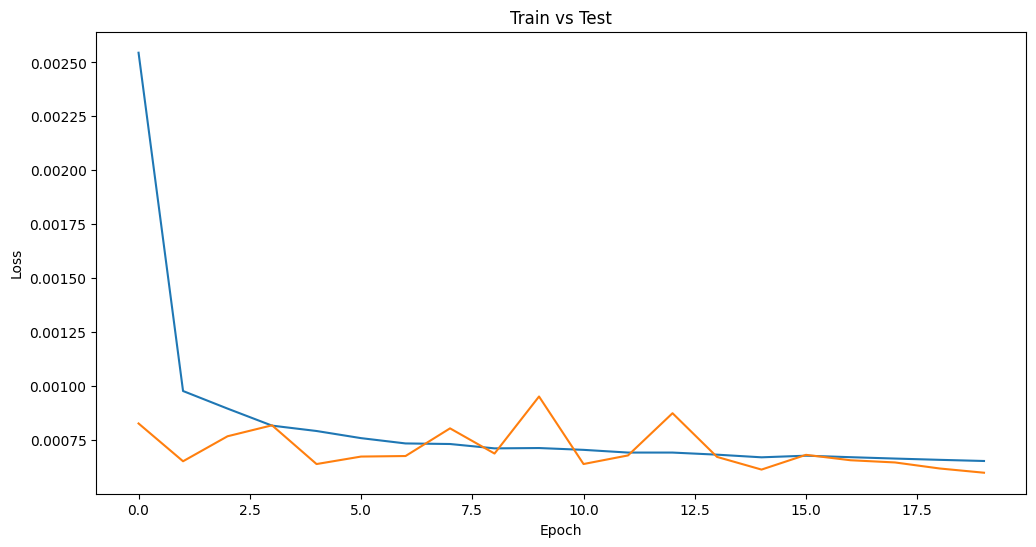

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')

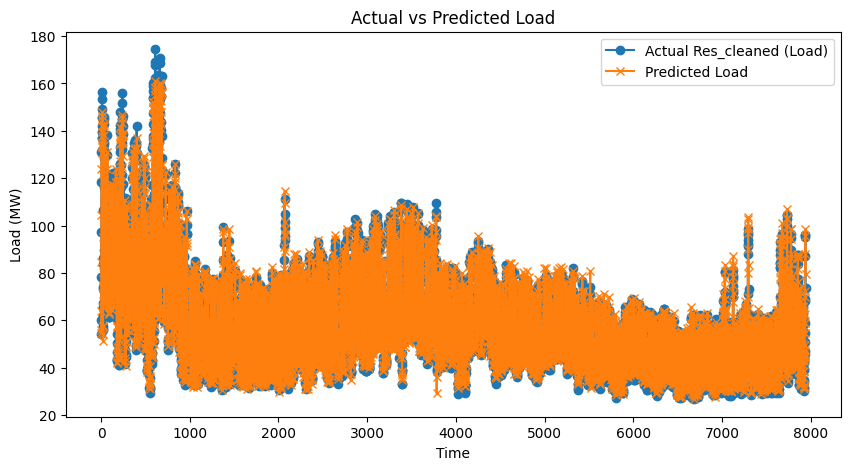

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual Res_cleaned (Load)', marker='o')
plt.plot(predictions_rescaled, label='Predicted Load', marker='x')
plt.title('Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()